In [1]:
from sklearn.datasets import load_diabetes, load_breast_cancer
from typing import Optional, Tuple
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})
import seaborn as sns
sns.set()
cp = sns.color_palette()
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import FrEIA.framework as ff
import FrEIA.modules as fm
from tqdm.notebook import tqdm
from IPython import display
import latent_dp

In [2]:
ds_name = "diabetes"  # "breast_cancer"
exec(f"ds = load_{ds_name}()")
x, y = torch.from_numpy(ds["data"]).cuda().float(), torch.from_numpy(ds["target"])

In [3]:
x = x / x.max(0, keepdim=True)[0]
x.max(dim=0)

torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'),
indices=tensor([204,   0, 367, 340, 230, 123,  58, 123,  23,  23], device='cuda:0'))

In [4]:
ds["feature_names"]

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

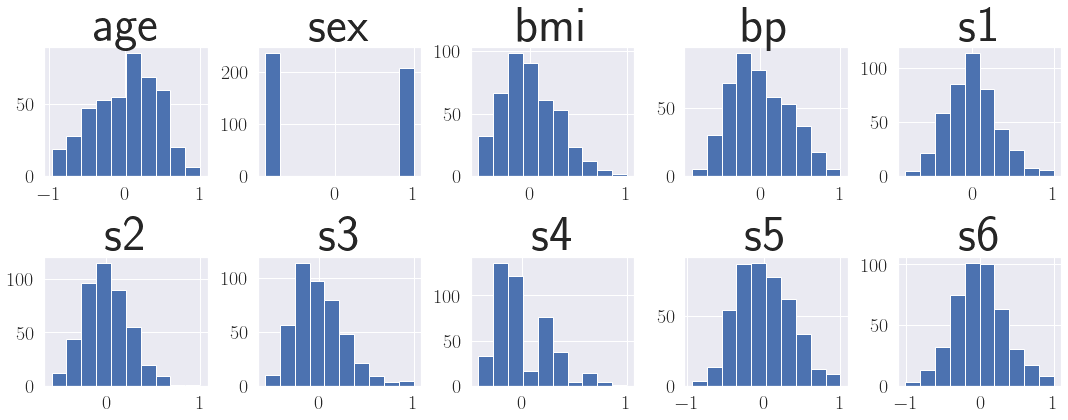

In [5]:
if ds_name == "diabetes":
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in enumerate(axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy())#, density=True)
    # hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    # ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label="dp")
    ax.set_title(ds["feature_names"][i], fontsize=50)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
# ax.legend(fontsize=40, loc="upper center", bbox_to_anchor=(1., 1.15)) #, ncol=2)

fig.tight_layout()
# fig.savefig(f"./experiments/categorical/features_diabetes.pdf", bbox_inches="tight")
plt.show()

In [6]:
n_blocks = 4
n_epochs = 5000
lr = 1e-4
noise_std = 0.02
rev_loss = False # True
register_forward_hook = True
plot_every = 50
coupling_block = fm.GINCouplingBlock # fm.GLOWCouplingBlock

def subnet_fc(dims_in: int, dims_out: int) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(dims_in, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, dims_out)
    )

In [7]:
nodes = [ff.InputNode(x.size(1), name="inp")]
cond = ff.ConditionNode(1)
for i in range(1, n_blocks + 1):
    nodes.append(ff.Node([nodes[-1].out0], fm.PermuteRandom, {"seed": i}, name=f"permute_{i}"))
    nodes.append(ff.Node([nodes[-1].out0], coupling_block, {"clamp": 2.0, "subnet_constructor": subnet_fc}, conditions=cond, name=f"coupling_{i}"))
nodes.append(ff.OutputNode([nodes[-1].out0], name="out"))
nodes.append(cond)

In [8]:
model = ff.ReversibleGraphNet(nodes, verbose=False).cuda()
# x, y = torch.cuda.FloatTensor(x), torch.cuda.FloatTensor(y)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
forward_plot_titles = [r"$\mathbf{x}$", *[f"t{i}" for i in range(1, 4)], r"$f_{\theta}(\mathbf{x})$"]
backward_plot_titles = [r"$f_{\theta}(\mathbf{z})$", *[f"t{i}" for i in range(1, 4)], r"$\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$"]

z = torch.randn(x.shape, device="cuda")

pbar = tqdm(range(n_epochs))
for e in pbar:
    feature_maps = []
    
    optimizer.zero_grad()
    x_noisy = x + torch.randn(x.shape, device=x.device) * noise_std
    if ds_name == "diabetes":
        x[:,1] = (x[:,1] > 0).float()
        cond = (x[:,1:2] > 0).float()
    elif ds_name == "breast_cancer":
        cond = y[:,None].cuda()
    out, jac = model(x_noisy, cond)
    zz = 0.5 * torch.sum(out**2, dim=1)
    nll = zz - jac
    loss = torch.mean(nll)
    loss.backward(retain_graph=rev_loss)
    
    #if rev_loss:
    #    z_noisy = torch.randn((x.size(0), 10), device="cuda")
        # z_noisy = z + torch.randn(x.shape, device=x.device) * noise_std
    #    recon, _ = model(z_noisy, rev=True)
    #    mse = F.mse_loss(recon, x)
    #    mse.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), 2)
    
    optimizer.step()
    out = out.cpu().detach()
    
    # if i % plot_every == 0:
    pbar.set_description(f"nll: {loss.item():.4f}") # | MSE: {mse.item():.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

In [70]:
revs_dp = []
for epsilon in [.5, 1., 3.]:
    laplace_dp = latent_dp.LaplaceMechanism(epsilon, .1)
    with torch.no_grad():
        if ds_name == "diabetes":
            cond = (x[:,1:2] > 0).float()
        elif ds_name == "breast_cancer":
            cond = y[:,None].cuda()
        z, _ = model(x, cond)
        # gm_sigma = sigma_gaussian_mechanism(z, epsilon, delta)
        z_dp = laplace_dp(z)
        cond = torch.randint_like(cond, 2)
        # z_dp = z + gm_sigma.cuda() * torch.randn(z.size()).cuda()
        rev_dp, _ = model(z_dp, cond, rev=True)
        rev, _ = model(z, cond, rev=True)
        revs_dp.append(rev_dp)

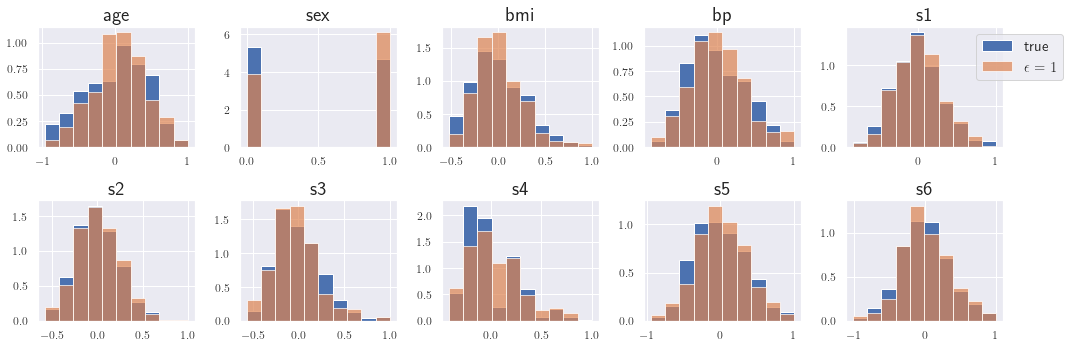

In [71]:
if ds_name == "diabetes":
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in enumerate(axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy(), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    for rev_dp, epsilon in zip(revs_dp[1:2], [1]):#revs_dp[::-1], [9, 6, 3]):
        hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
        ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label=r"$\epsilon = %d$" % int(epsilon))
    ax.set_title(ds["feature_names"][i], fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #if i == 6:
    #    break
    if i == 4:
        ax.legend(fontsize=15, loc="upper center", bbox_to_anchor=(1.1, 1.)) #, ncol=2)

fig.tight_layout()
#fig.savefig(f"./experiments/categorical/features_{ds_name}.pdf", bbox_inches="tight")
plt.show()

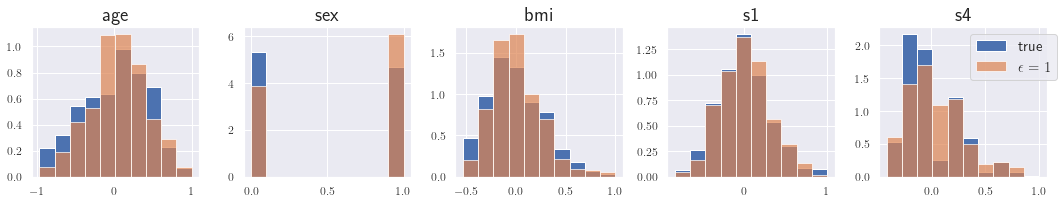

In [75]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
if ds_name == "diabetes":
    idx = [0, 1, 2, 4, 7]
    #idx = [3, 5, 6, 8, 9]
    #x_plot = x.cpu()[:,idx]
    feature_names = np.array(ds["feature_names"])[idx].tolist()
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in zip(idx, axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy(), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    
    for rev_dp, epsilon in zip(revs_dp[1:2], [1]):#revs_dp[::-1], [9, 6, 3]):
        try:
            hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
            ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label=r"$\epsilon = %d$" % int(epsilon))
        except:
            import pdb;pdb.set_trace()
    ax.set_title(ds["feature_names"][i], fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #if i == 6:
    #    break
    if i == idx[-1]:
        ax.legend(fontsize=15, loc="upper center", bbox_to_anchor=(.8, 1.)) #, ncol=2)

fig.tight_layout()
fig.savefig(f"./experiments/categorical/features_{ds_name}_example_features.pdf", bbox_inches="tight")
plt.show()

In [55]:
revs_dp

[tensor([[ 0.0019,  1.0372, -0.3269,  ..., -0.0188, -0.3334, -0.2200],
         [ 0.2152,  1.0421, -0.0699,  ...,  0.3560,  0.0079,  0.0917],
         [ 0.0503,  0.9950, -0.0035,  ..., -0.0571, -0.2159,  0.6879],
         ...,
         [ 0.3336, -0.0237, -0.1860,  ..., -0.0888, -0.1527,  0.4466],
         [ 0.7338,  1.0050, -0.0656,  ...,  0.1141, -0.1161,  0.4780],
         [ 0.0434,  0.0013,  0.7122,  ..., -0.2525, -0.3072, -0.0377]],
        device='cuda:0'),
 tensor([[ 0.3197,  0.9914,  0.0441,  ...,  0.1270,  0.0802,  0.4221],
         [ 0.2050, -0.0024, -0.1676,  ..., -0.2675, -0.3035, -0.0556],
         [-0.0227,  0.0092,  0.0384,  ..., -0.1473, -0.1803, -0.0707],
         ...,
         [-0.1393,  0.0046, -0.2635,  ..., -0.1911, -0.3173,  0.0290],
         [ 0.2556,  0.0063, -0.0801,  ..., -0.2888, -0.5460, -0.0602],
         [-0.4160,  0.0154, -0.0632,  ..., -0.0815, -0.3120, -0.4644]],
        device='cuda:0'),
 tensor([[-7.5361e-02,  3.2191e-03, -1.1900e-01,  ..., -1.8889e-01

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(x.size(1), 10)
        self.l2 = nn.Linear(10, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.l2(nn.functional.relu(self.l1(x)))

In [14]:
classifier = Classifier().cuda()
optim = torch.optim.Adam(classifier.parameters(), lr=1e-3)
epsilon = 100.

In [32]:
classifier = Classifier().cuda()
optim = torch.optim.Adam(classifier.parameters(), lr=1e-3)
for e in tqdm(range(1000)):
    optim.zero_grad()
    pred = classifier(x)
    if ds_name == "diabetes":
        loss = nn.functional.mse_loss(pred, y[...,None].cuda().float())
    elif ds_name == "breast_cancer":
        pred = torch.sigmoid(pred)
        loss = nn.functional.binary_cross_entropy(pred, y[:,None].cuda().float())
    loss.backward()
    optim.step()
print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

16063.0966796875


In [33]:
epsilon = 100.
laplace_dp = latent_dp.LaplaceMechanism(epsilon, out)
classifier = Classifier().cuda()
optim = torch.optim.Adam(classifier.parameters(), lr=1e-3)
for e in tqdm(range(1000)):
    optim.zero_grad()
    #if epsilon is not None:
    # x = rev_dp.detach().cuda()
    with torch.no_grad():
        if ds_name == "diabetes":
            cond = (x[:,1:2] > 0).float()
        elif ds_name == "breast_cancer":
            cond = y[:,None].cuda()
        z, _ = model(x, cond)
        z_dp = laplace_dp(z)
        x_dp, _ = model(z_dp, cond, rev=True)
    pred_dp = classifier(x_dp)
    if ds_name == "diabetes":
        loss = nn.functional.mse_loss(pred_dp, y[...,None].cuda().float())
    elif ds_name == "breast_cancer":
        pred = torch.sigmoid(pred)
        loss = nn.functional.binary_cross_entropy(pred_dp, y[:,None].cuda().float())
    loss.backward()
    optim.step()
print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

16000.1884765625


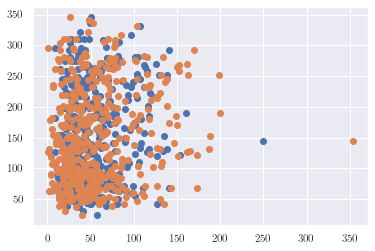

In [34]:
pred, y = pred.view(-1).cpu().detach(), y.view(-1).cpu()
pred_dp = pred_dp.view(-1).cpu().detach()
# plt.scatter(pred[(pred < 10000) & (pred > 0)], y[(pred < 10000) & (pred > 0)])
plt.scatter(pred, y)
plt.scatter(pred_dp, y)

In [161]:
pred[pred < 10000]

tensor([ 1.7595e+03, -2.3734e+04, -3.0265e+05, -2.1971e+03, -8.7640e+06,
        -3.4812e+04, -8.8689e+03,  6.2822e+03, -3.7083e+04,  2.2571e+03,
        -1.5220e+04, -1.0304e+05, -7.0010e+04, -1.2741e+04, -1.7069e+06,
        -1.1397e+04, -7.0286e+04, -1.0399e+05, -3.3676e+06,  2.0467e+03,
        -2.8303e+04,  9.8331e+02,  8.6012e+03, -1.3493e+05,  1.1968e+03,
        -1.4845e+04,  9.8490e+01, -2.7176e+06, -2.1853e+03,  2.1730e+02,
        -5.1340e+04,  1.7838e+03, -5.6797e+04,  5.9477e+03, -1.5302e+04,
         6.2480e+03, -4.6861e+03, -7.0953e+06,  7.9281e+02,  4.4878e+03,
        -2.7661e+05, -7.4031e+04,  6.9211e+03, -4.4801e+15, -5.8920e+04,
        -1.0251e+05, -1.6234e+02,  1.3043e+03, -1.4658e+06,  3.6751e+03,
        -1.0045e+05, -3.7021e+04, -1.3903e+04, -3.1914e+05, -7.4467e+04,
        -3.4761e+04, -7.0342e+04, -5.0503e+05, -1.2309e+07, -6.1214e+06,
         9.4519e+03, -4.0935e+03, -2.7927e+04, -4.6600e+05, -8.4269e+05,
        -4.0384e+04,  1.1622e+02, -5.7363e+03, -1.9

In [ ]:
pred = (pred > .5).float()
acc = (pred.view(-1).cpu() == y).sum() / y.size(0)
acc

In [ ]:
y.shape